#  从实验数据创建一个高精确度的模型

在本教程中，我们将了解从实验数据创建一个新的Dataset所涉及的内容。我们将看到，创建Dataset对象的机制只是整个过程的一小部分。大多数真实的数据集在适合用于训练模型之前都需要大量的清理和质量检查。

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Creating_a_high_fidelity_model_from_experimental_data.ipynb)



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

## 使用数据文件

假设你得到了一个你的实验合作伙伴收集的数据。你可能想用这些数据构建一个机器学习模型。

*你如何将这些数据转换为能够创建有用模型的数据集？*

从新数据构建模型可能会带来一些挑战。也许数据记录的方式不方便。此外，数据可能包含噪声。例如，由于大量的外部变量以及与收集多个样本相关的难度和成本，这在生物检测中是常见的。这是一个问题，因为你不希望你的模型拟合于这种噪声。

因此，主要有两个挑战：

* 解析数据
* 数据去噪

在本教程中，我们将通过一个例子，使用一个有药物实验数据的 excel 电子表格创建一个数据集。在我们深入这个例子之前，让我们简单回顾一下 DeepChem 的输入文件处理和特征化功能。

### 输入格式

DeepChem 支持各种输入文件。例如，可接受的文件格式包括 .csv、.sdf、.fasta、.png、.tif 和其他文件格式。特定文件格式的加载由与该格式关联的 `Loader` 类控制。例如，要加载一个 .csv 文件，我们使用 `CSVLoader` 类。下面是一个符合 `CSVLoader` 要求的 .csv文件示例。

1. 包含SMILES字符串的列。
2. 包含实验测量值的列。
3. (可选)包含唯一化合物标识符的列。

下面是一个输入文件示例。

|化合物ID       | log（溶解度）测量值，单位为摩尔/升           | smiles         |
|---------------|-------------------------------------------|----------------|
| 苯并噻唑       | -1.5                                      | c2ccc1scnc1c2  |


这里的“smiles”列包含 SMILES  字符串，“log（溶解度）测量值，单位为摩尔/升”包含实验测量值，“化合物ID”包含唯一的化合物标识符。

### 数据特征化

大多数机器学习算法要求输入数据为向量。然而，药物发现数据集的输入数据通常以分子列表和相关实验数据的形式出现。为了加载数据，我们使用 `dc.data.DataLoader` 的一个子类。例如 `dc.data.CSVLoader` 或 `dc.data.SDFLoader` 。用户可以子类化 `dc.data.DataLoader` 加载任意文件格式。所有的加载器都要求 `dc.feat.Featurizer` 对象作为参数，它指定如何将分子转换为向量。DeepChem 提供了 `dc.feat.Featurizer` 的许多不同子类。

## 解析数据

为了读取数据，我们将使用pandas数据分析库。 

为将药物名称转换为smiles字符串，我们将使用 pubchempy。这不是一个标准的 DeepChem 依赖，但你可以用 `conda install pubchemy` 来安装这个库。

In [2]:
!conda install pubchempy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13834 sha256=2a677d7eec60b4eaec7f32826134451245a9f9808eddca850ef6ce2a803fa7a4
  Stored in directory: c:\users\16606\appdata\local\pip\cache\wheels\30\15\b5\0a598aa268bb6c42360f1ce6398cd07bd395e4ee002bc6fb94
Successfully built pubchempy


In [1]:
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

Pandas 很神奇，但它不能自动知道在哪里找到你感兴趣的数据。你可能必须首先使用GUI查看数据集。

现在，我们来看看由 LibreOffice 渲染的这个数据集的截图。

为此，我们将导入 Image 和 os。

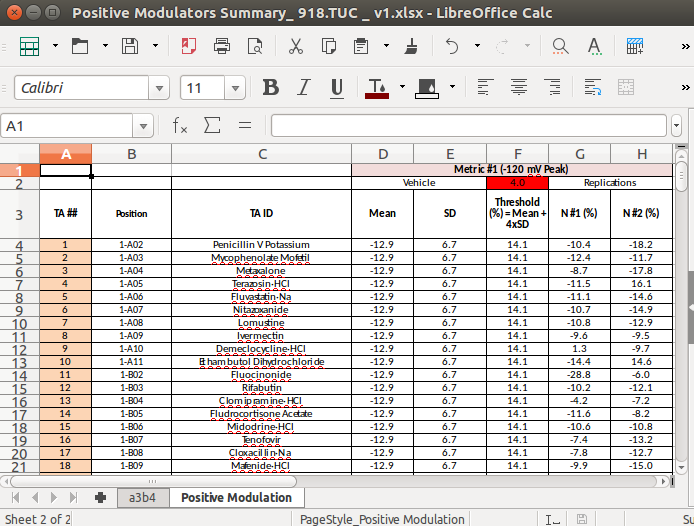

In [2]:
import os
from IPython.display import Image, display
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_screenshot = os.path.join(current_dir, 'assets/dataset_preparation_gui.png')
display(Image(filename=data_screenshot))

我们可以在第二页看到感兴趣的数据，包含在“TA ID”、“N #1(%)”和“N #2 (%)”列中。

此外，该电子表格的大部分格式似乎是为了便于人类阅读(多列标题，带有空格和符号的列标签，等等)。这使得创建一个整洁的数据框架对象变得更加困难。因此，我们将砍掉一切不必要的或不方便的东西。

In [5]:
raw_data_file = '..\..\datasets\Positive Modulators Summary_ 918.TUC _ v1.xlsx'
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [6]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.868936,6.747049,14.119261,-10.40397,-18.192942
3,2,1-A03,Mycophenolate Mofetil,-12.868936,6.747049,14.119261,-12.445268,-11.717468
4,3,1-A04,Metaxalone,-12.868936,6.747049,14.119261,-8.655724,-17.775287


注意，实际的行标题存储在第1行，而不是上面的第0行

In [7]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [9]:
# preview cleaner dataframe
raw_data

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.40397,-18.192942
1,3,Mycophenolate Mofetil,-12.445268,-11.717468
2,4,Metaxalone,-8.655724,-17.775287
3,5,Terazosin·HCl,-11.504804,16.082458
4,6,Fluvastatin·Na,-11.135366,-14.553018
...,...,...,...,...
425,427,Nilotinib,-10.912415,-10.926486
426,428,Cidofovir,4.942839,2.863256
427,429,Malathion,-0.00975,-5.685437
428,430,Ciprofloxacin,-7.269367,-7.632633


这种格式更接近我们所需要的。

现在，让我们用药物名称并获取它们的 smiles 字符串(DeepChem 所需的格式)。

In [10]:
drugs = raw_data['drug'].values

对于其中的大多数，我们可以通过 `get_compounds` 对象(使用 `pubchempy`)的 canonical_smiles 属性获得smiles字符串。

In [9]:
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [11]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

然而，其中一些药物名称有不同大小的空间和符号(·、(±)等)，pubchempy 可能无法读取这些名称。

对于这个任务，我们将通过普通表达式进行一些修改。同时，我们注意到所有离子都是以缩写形式写的，因此需要展开。因此，我们使用字典，将缩短的离子名称映射到 pubchempy 可识别的版本。

不幸的是，你可能会遇到一些极端情况，需要进行更多的修改。

In [12]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)
                   
    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

现在让我们把所有这些化合物转化为 smiles。这个转换将需要几分钟，所以这可能是一个去喝杯咖啡或茶，并在运行的时候休息的不错的时候！请注意，这种转换有时会失败，因此我们在下面添加了一些错误处理来捕获这种情况。

In [13]:
smiles_map = {}
for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
    except:
        print("Errored on %s" % i)
        continue

Errored on 216


In [14]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [15]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018


Hooray，我们已经将每个药物名称映射到对应的 smiles 代码。

现在，我们需要查看数据并尽可能多地去除噪声。

## 数据去噪（De-noising data）

在机器学习中，我们知道没有免费的午餐。你需要花时间分析和理解你的数据，以便构建你的问题并确定合适的模型框架。从这个过程中收集到的结论决定数据的处理方式。

要问自己的问题：

* 你想要完成什么？
* 你的化验结果是什么？
* 数据的结构是什么？
* 数据是否有意义？
* 以前尝试过什么？

对于本项目：

* 我想建立一个能够预测任意小分子药物对特定离子通道蛋白亲和力的模型
* 对输入的某个药物，数据描述通道抑制能力
* 几百种 n = 2 的药物
* 需要更仔细地观察数据集*
* 对于这种蛋白质，没有信息

* 这将涉及绘图，所以我们将导入 matplotlib 和 seaborn。我们还需要研究分子结构，因此我们将导入 rdkit。我们还将使用 seaborn 库，你可以使用 `conda install seaborn` 来安装它。

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

我们的目标是建立一个小分子模型，所以我们要确保我们的分子都很小。这可以用每个 smiles 字符串的长度来近似表示。

Text(0, 0.5, 'probability')

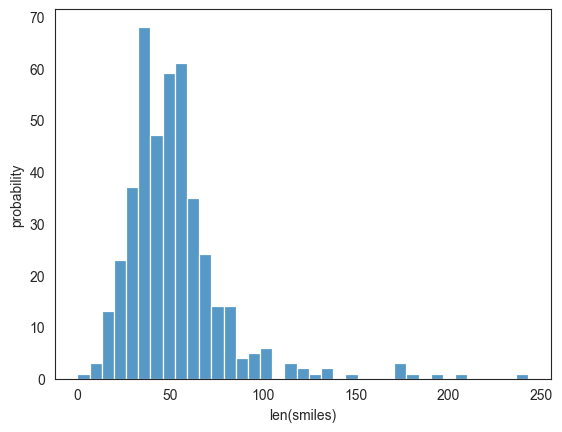

In [17]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

有些看起来相当大， len(smiles) > 150。让我们看看它们长什么样

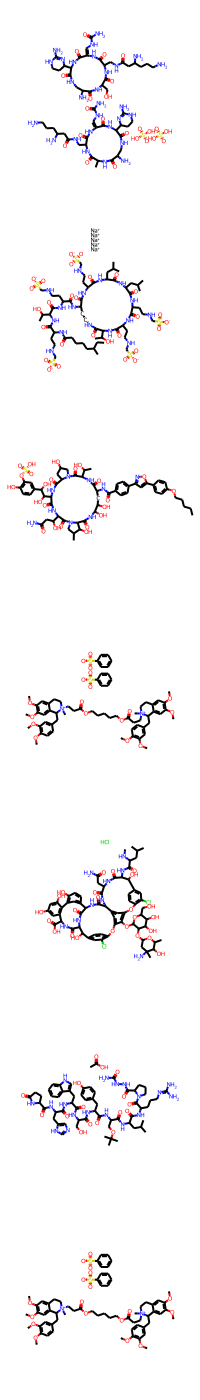

In [18]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=1)

正如怀疑的那样，这些不是小分子，所以我们将从数据集中删除它们。这里的论点是，这些分子可以作为抑制剂仅仅是因为它们很大。它们更有可能在空间上阻塞通道，而不是扩散到内部并结合(这是我们感兴趣的)。

这里的经验是删除不适合你的用例的数据。

In [19]:
# drop large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

现在，让我们看看数据集的数值结构。

首先，检查 NaN。

In [20]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
62,NaN,-7.826604
175,NaN,-6.612245
187,NaN,-8.233257
216,-12.345837,-12.944227
233,-8.21781,NaN
262,NaN,-12.878803
288,NaN,-2.34264
300,NaN,-8.199364
301,NaN,-10.46326
311,NaN,-8.787216


我不相信n=1，所以我不要它们了。

然后，让我们检验n1和n2的分布。

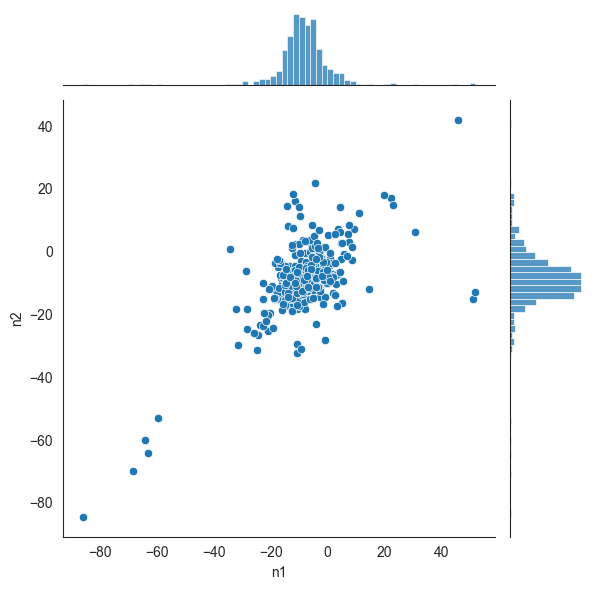

In [21]:
df = smiles_data.dropna(axis=0, how='any')
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data) 

我们看到大部分数据都包含在高斯团中，中心略低于零。我们可以看到，在左下方有几个明显有活性的数据点，右上方有一个。这些都与大多数数据有所区别。我们如何处理团中的数据?

因为n1和n2表示相同的测量值，理想情况下它们的值应该是相同的。这个图应该与对角线紧密对齐，皮尔逊相关系数应该是1。我们看到事实并非如此。这有助于我们对实验的误差有一个概念。

让我们更仔细地观察误差，绘制(n1-n2)的分布。

Text(0, 0.5, 'probability')

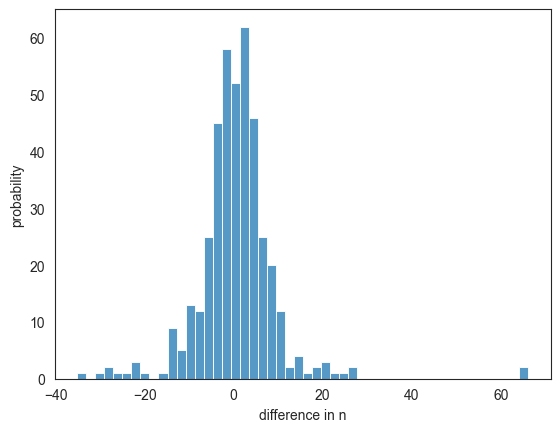

In [22]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

这看起来很像高斯分布，让我们通过 scipy 拟合高斯分布得到95%的置信区间，并取2个标准差。

In [23]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.810583114624023

现在，我不相信置信区间之外的数据，因此会从df中删除这些数据点。

例如，在上图中，至少有一个数据点的n1-n2 > 60。这是令人不安的。

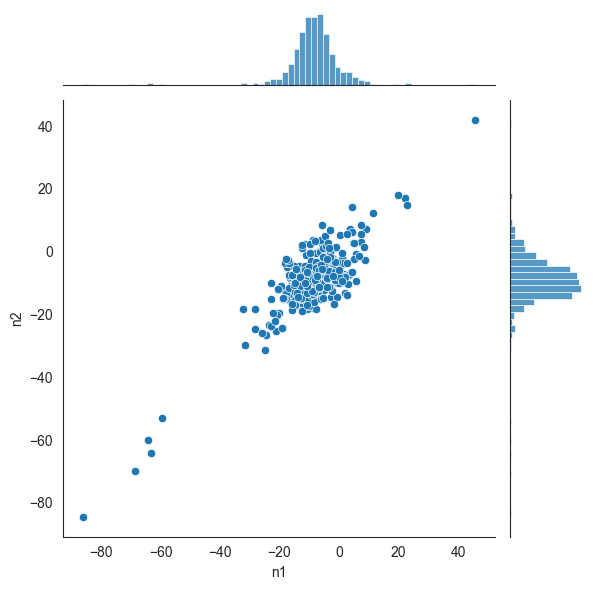

In [24]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df) 

现在数据看起来好多了!

我们求n1和n2的平均值，取误差条(error bar)为ci_95。

In [26]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

现在，让我们看一下带有误差条的排序数据。

Text(0, 0.5, 'activity')

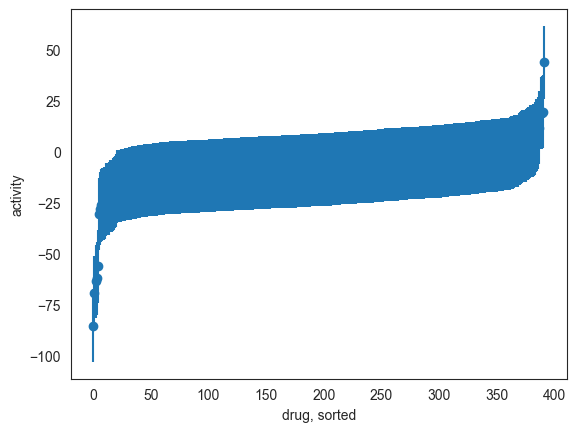

In [27]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

现在，我们来鉴定活性化合物。

在我的情况下，这需要领域知识。因为我在这一领域工作过，也咨询过这方面的专家，所以我对活性绝对值大于25的化合物很感兴趣。这与我们想要建模的期望药效有关。

如果你不确定如何在活动和非活动之间划清界限，则此界限可能被视为超参数

<ErrorbarContainer object of 3 artists>

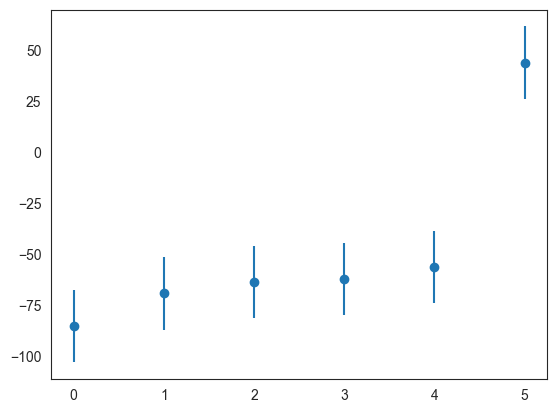

In [28]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [2]:
# summary
print(raw_data.shape, avg_df.shape, len(actives.index))

NameError: name 'raw_data' is not defined

综上所述，我们有：

* 删除了与我们希望回答的问题无关的数据（仅保留小分子数据）
* 删除了NaNs
* 确定了我们测量值的噪声
* 删了除异常嘈杂的数据点
* 确定了活性物（使用领域知识来确定一个阈值）

## 确定模型类型、数据集的最终形式和健全加载（sanity load）

现在，我们应该使用什么模型框架呢?

鉴于我们有392个数据点和6个活性物,这些数据将被用来建立一个被称为（ low data one-shot classifier）的分类器(10.1021/acscentsci.6b00367)。如果有类似性质的数据集，就可能使用迁移学习，但目前情况并非如此。

让我们将逻辑应用到数据中，以便将其转换为适合分类的二进制格式。

In [30]:
# 1 if condition for active is met, 0 otherwise
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

现在，将其保存到文件中

In [31]:
avg_df.to_csv('modulators.csv', index=False)

现在，我们将把这个数据框架转换为一个 DeepChem 数据集。

In [33]:
import deepchem as dc
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

d:\Program Files\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


最后，以某种方式对数据进行数值变换通常是有利的。例如，有时对数据进行归一化或将均值归零是很有用的。这取决于手头的任务。

DeepChem 内置了许多有用的变换器（transformer），位于 deepchem.transformers.transformers 类库。

因为这是一个分类模型，而且活性药物的数量很低，所以我将使用一个平衡变换器。当我开始训练模型时，我把这个变换器当作一个超参数。它被证明无疑地提高了模型的性能。

In [34]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

现在，让我们将平衡的数据集对象保存到硬盘，然后重新加载它作为健全性检查。

In [35]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')

Tutorial written by Keri McKiernan (github.com/kmckiern) on September 8, 2016

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!


# Bibliography

[2] Anderson, Eric, Gilman D. Veith, and David Weininger. "SMILES, a line
notation and computerized interpreter for chemical structures." US
Environmental Protection Agency, Environmental Research Laboratory, 1987.

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX. 

In [ ]:
@manual{Intro10, 
 title={Creating a high fidelity model from experimental data}, 
 organization={DeepChem},
 author={Eastman, Peter and Ramsundar, Bharath}, 
 howpublished = {\url{https://github.com/deepchem/deepchem/tree/master/examples/tutorials}}, 
 year={2021}, 
} 